In [3]:
# import the necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import shutil
import time
import copy

In [8]:
#Creating image datasets an data loaders for train and test using the experiments folder split
experiments_path = '/experiments/dest_folder/'
data_path = '/experiments/data/'


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(), 
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]), 
    'test' : transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [10]:
def get_train_files_path(experiments_path, data_path, phase):
    if phase == 'train':
        file_name = 'train.csv'
    elif phase == 'test':
        file_name = 'test.csv'
    else:
        print("phase can only have train and test as parameter values")
        exit()
    file_path = os.path.join(experiments_path, file_name)
    train_df = pd.read_csv(file_path, delimiter=',')
    files_path = []
    fonts_class = []
    for row in train_df.iterrows():
        files_path.append(os.path.join(data_path, row[1]['class'], row[1]['filename']))
        fonts_class.append(row[1]['class'])
    
    return files_path, fonts_class

In [11]:
def copy_images_to_path(file_path, file_class, destination_dir):
    font_folder = os.path.join(destination_dir, file_class)
    if os.path.exists(font_folder) == False:
        os.makedirs(font_folder)
    
    print("File being copied from {}:{}".format(file_path, font_folder))
    shutil.copy(file_path, font_folder)
    #shutil.copyfile(file_path, font_folder)

In [12]:
X_train, y_train = get_train_files_path(experiments_path, data_path, phase='train')
X_test, y_test = get_train_files_path(experiments_path, data_path, phase='test')

In [13]:
train_dir = os.path.join(experiments_path, 'train')
test_dir = os.path.join(experiments_path, 'test')

if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

In [14]:
for file_path, font_class in zip(X_train, y_train):
    copy_images_to_path(file_path, font_class, train_dir)

File being copied from /Users/kellymclean/face_recognition/observations/experiments/data/with_mask/0-with-mask.jpg:/Users/kellymclean/face_recognition/observations/experiments/dest_folder/train/with_mask
File being copied from /Users/kellymclean/face_recognition/observations/experiments/data/with_mask/10-with-mask.jpg:/Users/kellymclean/face_recognition/observations/experiments/dest_folder/train/with_mask
File being copied from /Users/kellymclean/face_recognition/observations/experiments/data/with_mask/100-with-mask.jpg:/Users/kellymclean/face_recognition/observations/experiments/dest_folder/train/with_mask
File being copied from /Users/kellymclean/face_recognition/observations/experiments/data/with_mask/101-with-mask.jpg:/Users/kellymclean/face_recognition/observations/experiments/dest_folder/train/with_mask
File being copied from /Users/kellymclean/face_recognition/observations/experiments/data/with_mask/103-with-mask.jpg:/Users/kellymclean/face_recognition/observations/experiments/d

In [15]:
image_datasets = {x: datasets.ImageFolder(os.path.join(experiments_path, x), data_transforms[x]) for x in ['train', 'test']}

In [16]:
image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 1315
    Root location: /Users/kellymclean/face_recognition/observations/experiments/dest_folder/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [17]:
image_datasets['test']

Dataset ImageFolder
    Number of datapoints: 194
    Root location: /Users/kellymclean/face_recognition/observations/experiments/dest_folder/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [18]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                                             batch_size=16, 
                                             shuffle=True, 
                                             num_workers=4) 
               for x in ['train', 'test']}

In [19]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x155e40fd0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x155a0c790>}

In [20]:
class_names = image_datasets['train'].classes

In [21]:
class_names

['with_mask', 'without_mask']

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
device

device(type='cpu')

In [24]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

In [25]:
#Visualizing images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

In [26]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)

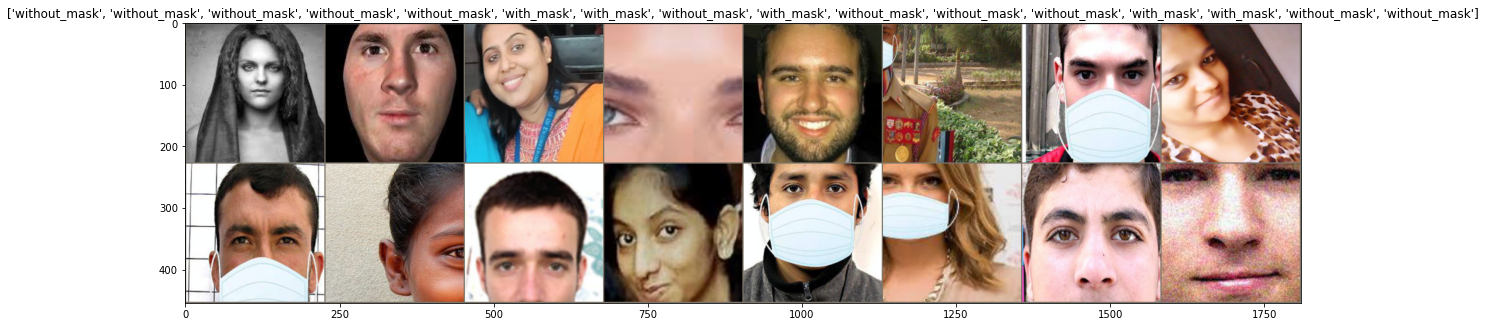

In [27]:
imshow(out, title=[class_names[x] for x in classes])

In [28]:
#Training the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()
    best_acc = 0.0
    best_model = copy.deepcopy(model.state_dict())
    
    new_freeze_state = None
    prev_freeze_state = False
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
        
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc:{:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model.state_dict())
            
            print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model)
    return model

In [29]:
import ssl

In [30]:
ssl._create_default_https_context = ssl._create_unverified_context

In [31]:
model_ft = models.resnet101(pretrained=True)

num_frts = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_frts, len(class_names))

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
optimizer_ft = optim.Adagrad(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [32]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=20)

Epoch 0/19
----------


/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:2929: UserWarning: image file could not be identified because WEBP support not installed
  warnings.warn(message)


UnidentifiedImageError: Caught UnidentifiedImageError in DataLoader worker process 3.
Original Traceback (most recent call last):
  File "/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 135, in __getitem__
    sample = self.loader(path)
  File "/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 171, in default_loader
    return pil_loader(path)
  File "/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/torchvision/datasets/folder.py", line 153, in pil_loader
    img = Image.open(f)
  File "/Users/kellymclean/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py", line 2931, in open
    "cannot identify image file %r" % (filename if filename else fp)
PIL.UnidentifiedImageError: cannot identify image file <_io.BufferedReader name='/Users/kellymclean/face_recognition/observations/experiments/dest_folder/train/without_mask/indian-ethnicity-cheerful-confident-studio-260nw-552325924.jpg'>


In [33]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    #fig = plt.figure(figsize=(10,10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            print(preds,"predicitons")
            
            
            for j in range(inputs.size()[0]):
                images_so_far +=1
                #ax = plt.subplot(num_images//len(labels)-1, len(labels), images_so_far)
                #ax.axis('off')
                #ax.set_title('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                print('true: {} predicted: {}'.format(class_names[labels[j]], class_names[preds[j]]))
                #imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
torch.save(model_ft, 'mask1_model_resnet101.pth')

In [ ]:
visualize_model(model_ft)